# Datamining 7331 Minilab: Analysis of Airbnb data using Logistic Regression and SVM

By: William Arnost, Stephen Johnson, Sean Kennedy, Tazeb Abera

## Introduction

In this notebook we will be predicting the room type feature from the Airbnb data set using Logistic Regression and Support Vector Machines. Room type can take 3 values: 'Private room', 'Entire home/apt', and 'Shared room'. Room type by itself might not be a useful thing to predict, but we are hoping this can teach us something about our data for a future price prediction exercise. We will compare accuracy between the two algorithms, as well as look at hyperparameter tuning for each one. Then we discuss which model was more useful and look at the interpretation of the features. 

---
## Contents

* <a href="#DataPreperation">Data Preperation</a>
* <a href="#CreateModels">Create Models</a>
* <a href="#ModelAdvantages">Model Advantages</a>
* <a href="#InterpretFeatureImportance">Interpret Feature Importance</a>
* <a href="#InterpretSupportVectors">Interpret Support Vectors</a>
* <a href="#Conclusion">Conclusion</a>



---
<a id="Loading"></a>
<a href="#top">Back to Top</a>

<a id="DataPreperation"></a>
# Data Preperation

This section is where we load and prepare our data. This was not part of the grading rubric so we do not present any modeling or analysis here.

### Package Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
#sns.set(style="ticks", color_codes=True)
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Define Functions for model analysis

In [48]:
def analyze_classifier(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1]):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    if len(classes) == 2:
        disc_thresh = DiscriminationThreshold(model)
        disc_thresh.fit(X_train, y_train.values.ravel())
        disc_thresh.show()
        return disc_thresh.thresholds_, disc_thresh.cv_scores_
    else:
        return None, None


def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([
        pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']),
        predictions
    ],
                                axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(
        lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={
        0: 'No_Predicted',
        1: 'Yes_Predicted'
    },
                  index={
                      0: 'No_True',
                      1: 'Yes_True'
                  },
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),
                 5), matrix, predicted_probs

### Read in the data

In [3]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x: len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ZIP,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48871.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,10675.111211,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,599.591915,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,10001.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,10024.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,11104.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,11221.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,11697.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000


### Type Conversion

In [4]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data[
    'calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])

data['days_since_last_review'] = (
    dt.datetime.strptime('2020-01-01', '%Y-%m-%d') -
    data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(),
                                   inplace=True)
data.drop(columns=['last_review'], inplace=True)

### Remove Outliers

In [5]:
data = data[data.price != 0].copy()
data = data[data.price < 300].copy()
data = data[data.minimum_nights <= 20].copy()

In [6]:
idx = data[data['room_type'] == 'Shared room'].index
data.drop(idx , inplace=True)

#Add Note here

### Encode Target Variable

In [7]:
target_col = 'room_type'
room_types = {'Entire home/apt': 0, 'Private room': 1}
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)

### Drop Columns that won't be used in modeling

In [8]:
data.drop(
    columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'ZIP'],
    inplace=True)

### Feature / Target Split

In [9]:
data_final = data
features, target = data_final.drop(
    columns=['Response']), data_final.loc[:, ['Response']]
features.shape, target.shape

((39156, 20), (39156, 1))

<a id="CreateModels"></a>
# Create Models

[50] Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

## Splitting and Encoding Data for Modeling

### Train / Test Split

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000001CC2C7FF4A8>,
       colormap=None, colors=None,
       labels=['Entire home/apt', 'Private room'])

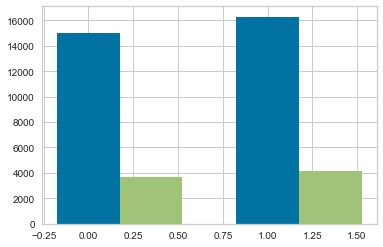

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0)
classes_test = ClassBalance(
    labels=['Entire home/apt', 'Private room'])
classes_test.fit(y_train['Response'], y_test['Response'])

We split the data set into 80% Train and 20% Test. The bar graph above shows the split by level of our response variable room type. Its good to note that 'Shared room' has a small number of observations compared to the other two classes.

### Data Transforms
- One Hot Encode all categoricals
- Standard Scale all numerics (sklearn is not R - it does not do this by default)
- This needs to be done on train/test set separately (create a pipeline) 

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/compose.html#combining-estimators

In [11]:
#OH encode
label_encode = [
    x for x, y in dict(X_train.dtypes).items()
    if type(y) == pd.CategoricalDtype
]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    X_train[var].fillna(X_train[var].mode()[0], inplace=True)
    X_test[var].fillna(X_train[var].mode()[0], inplace=True)
    cat_list_train = pd.get_dummies(X_train[var], prefix=var)
    cat_list_test = pd.get_dummies(X_test[var], prefix=var)
    X_train_new = X_train.join(cat_list_train)
    X_train = X_train_new
    X_test_new = X_test.join(cat_list_test)
    X_test = X_test_new

normalize = [x for x, y in dict(X_train.dtypes).items() if y == np.float64]
for col in normalize:
    #change impution scheme?
    print(f"{col} was Standard Scaled")
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_test[col].fillna(X_train[col].median(), inplace=True)
    normalizer = StandardScaler()
    ar_train = X_train[col].to_numpy().reshape(-1, 1)
    normalizer.fit(ar_train)
    X_train.loc[:, col] = normalizer.transform(ar_train)
    ar_test = X_test[col].to_numpy().reshape(-1, 1)
    X_test.loc[:, col] = normalizer.transform(ar_test)

X_train.drop(columns=label_encode, inplace=True)
X_test.drop(columns=label_encode, inplace=True)
X_train.drop(columns=target_col, inplace=True)
X_test.drop(columns=target_col, inplace=True)

neighbourhood_group was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


D:\Users\William\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


1. Explain OHE
2. Explain Missing Imputation
3. Explain normalization

### Baseline Accuracy

In [13]:
base_line_accuracy_train = {
    'class_0': (y_train[y_train.Response == 0].shape[0] / y_train.shape[0]),
    'class_1': (y_train[y_train.Response == 1].shape[0] / y_train.shape[0]),
    'class_2': (y_train[y_train.Response == 2].shape[0] / y_train.shape[0])
}
base_line_accuracy_test = {
    'class_0': (y_test[y_test.Response == 0].shape[0] / y_test.shape[0]),
    'class_1': (y_test[y_test.Response == 1].shape[0] / y_test.shape[0]),
    'class_2': (y_test[y_test.Response == 2].shape[0] / y_test.shape[0])
}

print(base_line_accuracy_train)
print(base_line_accuracy_test)

{'class_0': 0.48014302132550124, 'class_1': 0.5198569786744988, 'class_2': 0.0}
{'class_0': 0.4726762002042901, 'class_1': 0.5273237997957099, 'class_2': 0.0}


We could achieve 50% - 51% accuracy by predicting class 1 all the time (Private room). Hopefully our models do better!

## Logistic Regression

In [35]:
logistic = LogisticRegression(
     max_iter=10000
    ,fit_intercept=True # always fit an intercept term
    ,n_jobs=-1 # use all processors
)
pipe = Pipeline(steps=[('logistic', logistic)])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'logistic__C': np.logspace(-4, 2, 10),
    #'logistic__class_weight':[None, 'balanced'],
    'logistic__penalty':['l1', 'l2'],
    #'logistic__multi_class':['auto', 'ovr', 'multinomial'],
    #'logistic__dual':[True, False],
    #'logistic__solver':['lbfgs', 'liblinear', 'sag', 'saga']
}

search_lr = GridSearchCV(pipe, param_grid, n_jobs=-1,error_score=0.0,scoring='accuracy')
search_lr.fit(X_train, y_train.values.ravel())
print("Best parameter (Accuracy score=%0.3f):" % search_lr.best_score_)
print(search_lr.best_params_)
results_lr = pd.DataFrame(search_lr.cv_results_)
results_lr.sort_values(by='mean_test_score', ascending=False)

D:\Users\William\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Best parameter (Accuracy score=0.834):
{'logistic__C': 1.0, 'logistic__penalty': 'l1'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_logistic__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
19,0.577904,0.018412,0.002667,0.000471,100,l2,"{'logistic__C': 100.0, 'logistic__penalty': 'l2'}",0.837387,0.833254,0.830955,0.833865,0.002662,1,0.832775,0.832687,0.835081,0.833514,0.001109
12,1.504080,0.533757,0.006336,0.004716,1,l1,"{'logistic__C': 1.0, 'logistic__penalty': 'l1'}",0.837100,0.833349,0.831146,0.833865,0.002458,1,0.832870,0.832687,0.835368,0.833642,0.001223
18,0.435877,0.020763,0.007335,0.001701,100,l1,"{'logistic__C': 100.0, 'logistic__penalty': 'l1'}",0.837387,0.833254,0.830955,0.833865,0.002662,1,0.832823,0.832735,0.835081,0.833546,0.001086
17,0.832298,0.051439,0.004670,0.000472,21.5443,l2,"{'logistic__C': 21.54434690031882, 'logistic__...",0.837387,0.833254,0.830955,0.833865,0.002662,1,0.832775,0.832687,0.835081,0.833514,0.001109
16,0.528453,0.121315,0.016007,0.012757,21.5443,l1,"{'logistic__C': 21.54434690031882, 'logistic__...",0.837387,0.833254,0.830955,0.833865,0.002662,1,0.832823,0.832687,0.835081,0.833530,0.001098
14,1.396192,0.784227,0.007004,0.002946,4.64159,l1,"{'logistic__C': 4.641588833612772, 'logistic__...",0.837292,0.833158,0.831146,0.833865,0.002558,1,0.832823,0.832687,0.835081,0.833530,0.001098
15,0.965922,0.062344,0.011005,0.004321,4.64159,l2,"{'logistic__C': 4.641588833612772, 'logistic__...",0.837292,0.833254,0.830859,0.833802,0.002655,7,0.832823,0.832687,0.835225,0.833578,0.001166
13,1.019231,0.100644,0.010336,0.001699,1,l2,"{'logistic__C': 1.0, 'logistic__penalty': 'l2'}",0.836909,0.833445,0.830955,0.833770,0.002441,8,0.832966,0.832735,0.835464,0.833722,0.001236
10,0.548457,0.093883,0.009334,0.002626,0.215443,l1,"{'logistic__C': 0.21544346900318823, 'logistic...",0.837675,0.832870,0.830380,0.833642,0.003028,9,0.832200,0.832591,0.835225,0.833339,0.001343
11,1.014233,0.083890,0.008667,0.001246,0.215443,l2,"{'logistic__C': 0.21544346900318823, 'logistic...",0.837292,0.833062,0.830189,0.833514,0.002917,10,0.832439,0.832687,0.835608,0.833578,0.001439


Here we ran a grid search over two parameters, cost and penalty. We tried 10 different values of cost and two values for penalty (l1, l2). We also set the error_score to zero which helps keep invalid parameter combinations from crashing the grid search.

We printed the results of the search sorted by mean_test_score, with the best scores at the top. Two models tied for the best score: [C=100, penalty=l2] and [C=1, penalty=l1]

AxesSubplot(0.125,0.125;0.775x0.755)


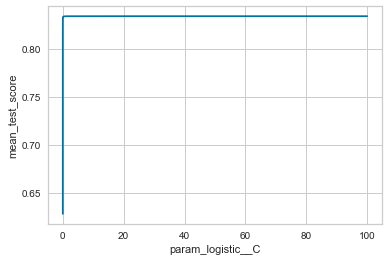

In [38]:
p1a = sns.lineplot(x="param_logistic__C", y="mean_test_score", data=results_lr, ci=None)


print(p1a)


Here I am showing how accuracy is changing for different values of C. It appears most of the change happens near zero, so we need to zoom in to see the detail.

[(0, 0.1)]


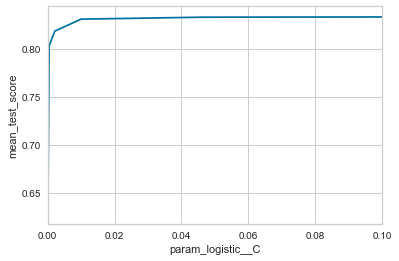

In [40]:
p1b = sns.lineplot(x="param_logistic__C", y="mean_test_score", data=results_lr, ci=None).set(xlim=(0,0.1))
print(p1b)

Here we can see that most of the improvement comes between C=0 and C=0.01, beyond that the accuracy does not improve much for this data.

AxesSubplot(0.125,0.125;0.775x0.755)


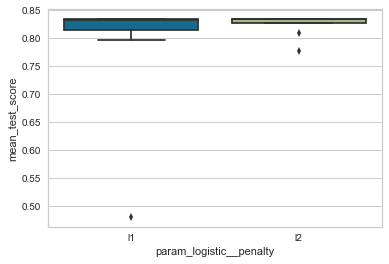

In [43]:
p2 = sns.boxplot(x="param_logistic__penalty", y="mean_test_score", data=results_lr)
print(p2)

This boxplot shows the range of accuracies attained by penalty, l1 and l2. Both achieved similar overall levels of accuracy but the range for l2 was much narrower, suggesting it is more consistant. That said, l1 has a pretty narrow range except for the outlier below 50% accuracy. This point had C=0.0001, which is the lowest value we tried. Extremely low values of C should be avoided for this data.

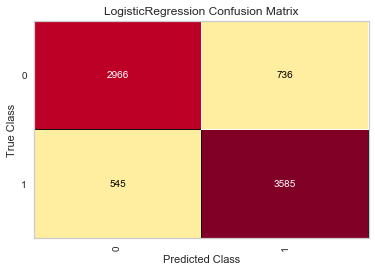

Model Accuracy 0.83644


In [59]:
best_logistic = LogisticRegression(
    C = search_lr.best_params_['logistic__C'],
    penalty=search_lr.best_params_['logistic__penalty'],
    fit_intercept=True
)
best_logistic.fit(X_train, y_train.values.ravel())
#cutoffs_lgrg_all, scores_lgrg_all = analyze_classifier(best_logistic, X_train,
#                                                       X_test, y_train, y_test)
matrix = ConfusionMatrix(best_logistic, classes=[0,1])
matrix.fit(X_train, y_train['Response'])
matrix.score(X_test, y_test['Response'])
matrix.show()

predict_logit_all = best_logistic.predict(X_test)
prob_logit_all = best_logistic.predict_proba(X_test)
acc_logit_all = round(accuracy_score(y_test, predict_logit_all), 5)
print(f'Model Accuracy {acc_logit_all}')

Here we are showing the confusion matrix for our best logistic model. It achieves an accuracy of 83.6% There seem to be more false positives than false negatives, but since the positive class ('Private Room') has more observations it doesn't seem surprising that the model would predict that class more often.

## Support Vector Machine

In [28]:
### THIS TAKES LIKE 2 HOURS to RUN
from sklearn.svm import SVC

param_grid_svm = {
    'C': np.logspace(-4, 1, 10),
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}
#search = GridSearchCV(SVC(), param_grid_svm, n_jobs=-1,error_score=0.0,scoring='accuracy')
#search.fit(X_train, y_train.values.ravel())
#print("Best parameter (Accuracy score=%0.3f):" % search.best_score_)
#print(search.best_params_)
#results = pd.DataFrame(search.cv_results_)
#results.sort_values(by='mean_test_score', ascending=False)

Best parameter (Accuracy score=0.868):
{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,86.285918,0.801971,17.961899,1.182865,0.0001,0.001,linear,"{'C': 0.0001, 'gamma': 0.001, 'kernel': 'linear'}",0.778395,0.766785,0.768221,0.771134,0.005168,58,0.768174,0.771824,0.772399,0.770799,0.001871
1,131.795329,7.300214,19.313591,1.275649,0.0001,0.001,rbf,"{'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}",0.519824,0.519874,0.519874,0.519857,0.000023,69,0.519874,0.519849,0.519849,0.519857,0.000012
2,86.014498,0.518270,15.584045,3.179215,0.0001,0.01,linear,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'linear'}",0.778395,0.766785,0.768221,0.771134,0.005168,58,0.768174,0.771824,0.772399,0.770799,0.001871
3,133.882917,7.753661,19.660300,1.228103,0.0001,0.01,rbf,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}",0.519824,0.519874,0.519874,0.519857,0.000023,69,0.519874,0.519849,0.519849,0.519857,0.000012
4,86.592649,0.536066,13.730730,2.494483,0.0001,0.1,linear,"{'C': 0.0001, 'gamma': 0.1, 'kernel': 'linear'}",0.778395,0.766785,0.768221,0.771134,0.005168,58,0.768174,0.771824,0.772399,0.770799,0.001871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,40.944005,1.062397,3.295139,0.123763,10,0.01,rbf,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.871959,0.866488,0.865339,0.867929,0.002889,1,0.871372,0.872576,0.872911,0.872286,0.000661
76,137.544062,7.588269,1.921065,0.061043,10,0.1,linear,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'linear'}",0.838824,0.837755,0.835265,0.837281,0.001491,20,0.836845,0.836853,0.838194,0.837297,0.000634
77,66.027664,1.568375,3.639826,0.067012,10,0.1,rbf,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.865639,0.859113,0.862848,0.862534,0.002673,5,0.913753,0.914093,0.917157,0.915001,0.001531
78,122.836865,6.584762,1.500875,0.197916,10,1,linear,"{'C': 10.0, 'gamma': 1, 'kernel': 'linear'}",0.838824,0.837755,0.835265,0.837281,0.001491,20,0.836845,0.836853,0.838194,0.837297,0.000634


Here  We are running a grid search over three different parameters: C, gamma, and kernel. The results are sorted by mean_test_score. Our best model used an rbf kernel with C= 0.0001 and gamma = 0.001. This procedure takes hours to run.

In [60]:
import pickle as pickle
with open('svm_search.pkl', 'wb') as output:
    pickle.dump(search, output, pickle.HIGHEST_PROTOCOL)


This code is used to store the search output. Due to run time we don't want to run it every time we reload the notebook.

In [61]:
import pickle as pickle
with open('svm_search.pkl', 'rb') as input:
    search = pickle.load(input)
print("Best parameter (Accuracy score=%0.3f):" % search.best_score_)
print(search.best_params_)
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='mean_test_score', ascending=False)

Best parameter (Accuracy score=0.868):
{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
75,40.944005,1.062397,3.295139,0.123763,10,0.01,rbf,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.871959,0.866488,0.865339,0.867929,0.002889,1,0.871372,0.872576,0.872911,0.872286,0.000661
61,58.556881,2.917216,3.826900,0.196379,0.774264,0.1,rbf,"{'C': 0.7742636826811278, 'gamma': 0.1, 'kerne...",0.869278,0.864572,0.863806,0.865886,0.002419,2,0.881190,0.884164,0.884787,0.883380,0.001570
69,48.210175,0.546257,3.552951,0.172671,2.78256,0.1,rbf,"{'C': 2.782559402207126, 'gamma': 0.1, 'kernel...",0.871768,0.861699,0.863615,0.865694,0.004366,3,0.895317,0.899248,0.899823,0.898129,0.002003
67,40.187945,1.070304,3.852338,0.044662,2.78256,0.01,rbf,"{'C': 2.782559402207126, 'gamma': 0.01, 'kerne...",0.866118,0.864477,0.861891,0.864162,0.001740,4,0.866632,0.868075,0.868170,0.867625,0.000704
77,66.027664,1.568375,3.639826,0.067012,10,0.1,rbf,"{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.865639,0.859113,0.862848,0.862534,0.002673,5,0.913753,0.914093,0.917157,0.915001,0.001531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,122.636578,0.664448,19.521333,0.147479,0.0001,1,rbf,"{'C': 0.0001, 'gamma': 1, 'kernel': 'rbf'}",0.519824,0.519874,0.519874,0.519857,0.000023,69,0.519874,0.519849,0.519849,0.519857,0.000012
31,123.320166,2.168576,14.422714,0.180427,0.00464159,1,rbf,"{'C': 0.004641588833612782, 'gamma': 1, 'kerne...",0.519824,0.519874,0.519874,0.519857,0.000023,69,0.519874,0.519849,0.519849,0.519857,0.000012
5,150.486858,5.261486,18.790198,1.820260,0.0001,0.1,rbf,"{'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}",0.519824,0.519874,0.519874,0.519857,0.000023,69,0.519874,0.519849,0.519849,0.519857,0.000012
3,133.882917,7.753661,19.660300,1.228103,0.0001,0.01,rbf,"{'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}",0.519824,0.519874,0.519874,0.519857,0.000023,69,0.519874,0.519849,0.519849,0.519857,0.000012


This chunk prints the results after loading the search object. This is used if we don't want to re-run the grid search.

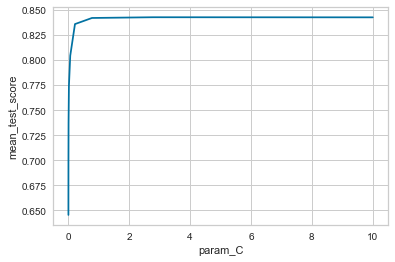

In [65]:
results2 = results[results.mean_test_score > 0]
#sns.set(style='darkgrid')
p1a = sns.lineplot(x="param_C", y="mean_test_score", data=results2, ci=None)

Here we can see accuracy for different values of C. There is not much accuracy improvement above C=1

AxesSubplot(0.125,0.125;0.775x0.755)


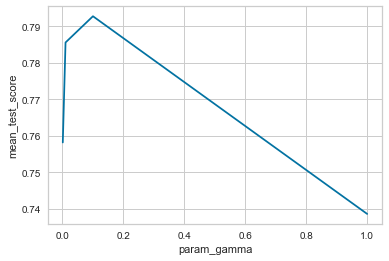

In [66]:
p2 = sns.lineplot(x="param_gamma", y="mean_test_score", data=results2, ci=None)
print(p2)

This chart is showing accuracy at different levels of gamma. Values of gamma less than 0.2 perform the best, then decline steadily as we approach gamma=1

AxesSubplot(0.125,0.125;0.775x0.755)


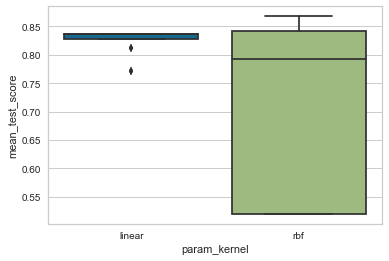

In [67]:
p3 = sns.boxplot(x="param_kernel", y="mean_test_score", data=results2)
print(p3)

The linear kernel performs well and is very consistant. The rbf kernel has the best overall accuracy but it is not consistant, with its lowest values approaching our baseline accuracy.

AxesSubplot(0.125,0.125;0.775x0.755)


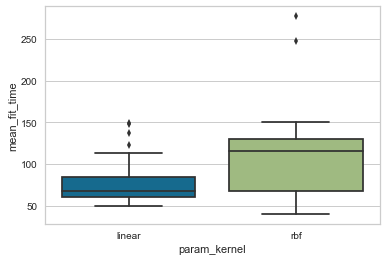

In [68]:
p4 = sns.boxplot(x="param_kernel", y="mean_fit_time", data=results2)
print(p4)

The linear kernel takes less time to train than the rbf kernel. Depending on the application, the extra time may not be worth the small gains in accuracy.

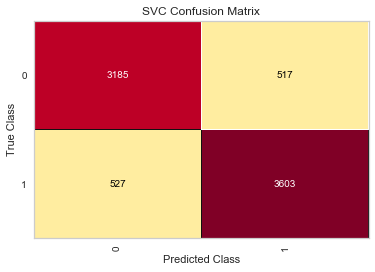

Model Accuracy 0.8667


In [71]:
best_svm = SVC(
    C = search.best_params_['C'],
    gamma=search.best_params_['gamma'],
    kernel=search.best_params_['kernel']
)
best_svm.fit(X_train, y_train.values.ravel())
#cutoffs_lgrg_all, scores_lgrg_all = analyze_classifier(best_logistic, X_train,
#                                                       X_test, y_train, y_test)
matrix = ConfusionMatrix(best_svm, classes=[0,1])
matrix.fit(X_train, y_train['Response'])
matrix.score(X_test, y_test['Response'])
matrix.show()

predict_svm = best_svm.predict(X_test)
#prob_logit_all = best_svm.predict_proba(X_test)
acc_svm = round(accuracy_score(y_test, predict_svm), 5)
print(f'Model Accuracy {acc_svm}')

The best svm model achieved 86.67% Accuracy. It had more balanced false positive/negatives than logistic regression

<a id="ModelAdvantages"></a>
# Model Advantages

[10] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

On Accuracy, SVM was most accurate with the best model achieving 86.67% accuracy vs 83.64% for logistic regression. That said, SVM was less consistant when using the rbf kernel, with many lower scores. Logistic regression was more consistant over parameters we searched. The linear kernel for SVM achieved accuracy similar to that of logistic regression.

On Training Time / Efficiency, logistic performed much better. The grid search for logistic regression took under a minute, where the SVM grid search often takes between 30 minutes and 2 hours depending on the grid space, and could easily take more if we expanded it. 

Add Charts?

<a id="InterpretFeatureImportance"></a>
# Interpret Feature Importance

[30] Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/

Regression coefficients in LogisticRegression are the log odds of predicting class True/1/Positive class ('Shared Room') over False/0/Negative ('Entire Home/Apt') class.

In this case - any feature that has a negative OddsRatio (Beta) - will tilt tilt the prediction towards the negative class by the amount exp^Beta-1.

Continuous:
Hence increases in one unit of price increases the likelihood of predicting the false class ('Entire Home/Apt') by 92%. Inuitively, this makes sense, it is more expensive to rent an entire home than a shared room. Minimum nights and longitude were also variables where increases in value tilted predictions towards the negative class. availability_365 is a continuous predictor that tilts predictions towards the positive class. This also makes sense, since on average, availaibility_365 was higher for shared_rooms over Entire/Home apt

Categorical:
For categroical variables, the most predictive feature was 'Staten Island' (87% increase in odds for the False class) - this is also somewhat intuitive - given that the class balance between Shared Room and Entire Home/Apt was had the least imbalance in Staten Island vs the other boroughs.

In [72]:
odds = pd.DataFrame(best_logistic.coef_[0], index=X_train.columns).rename(columns={0:'OddsRatio'})
odds['OddsChangePerUnitIncrease'] = np.exp(odds.OddsRatio) - 1
odds.reindex(odds.OddsRatio.abs().sort_values(ascending=False).index)

,OddsRatio,OddsChangePerUnitIncrease
price,-2.576627,-0.923970
neighbourhood_group_Staten Island,-2.037791,-0.869684
availability_365,0.545080,0.724747
cnt_private_room,0.532901,0.703869
neighbourhood_group_Brooklyn,-0.399958,-0.329652
avgprice_private_room,0.368856,0.446079
minimum_nights,-0.362149,-0.303822
longitude,-0.290102,-0.251812
cnt_entire_home,-0.288023,-0.250255
days_since_last_review,0.274428,0.315778


<a id="InterpretSupportVectors"></a>
# Interpret Support Vectors

[10] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

<a id="Conclusion"></a>
# Conclusion

In [27]:
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#